# Introduction

---

## Purpose of this notebook

This Colab notebook serves as a personal workbook to guide you (and me) through coding makemore from scratch.

I like to try to code some of Andrej Karpathy's 'Zero-to-Hero' projects from scratch every now and again.

By following this workbook, you can regularly practice and internalize the process of building makemore from the ground up.

Each time you start a new Colab, simply copy over the instructions cell and build upon it.

[Go to makemore](https://github.com/karpathy/makemore)

---

## Lessons from Makemore Lecture 1

### Train a language model using two different approaches and get the same result.
- First way: Language modeling using bigram counts (circa 1980's).
- Second way: Language modeling using neural network (single layer followed by softmax) with gradient based optimization

### Negative log likelihood
- Great exploration of negative log likelihood
- Evaluate the quality of a model (using negative log likelihood)
- Using negative log likelihood as a guide to optimizing a neural network

### Other topics
- Sampling from the model (using torch.multinomial)
- Training loop (fundamentally not much different from transformer)

### Pre-requisites:
 - Micrograd. (Then you will really appreciate Pytorch).


# Instructions

In [ ]:
# Makemore (training two bigram character level language models)

# Part 1: Language modeling via Bigram counts

#  - Download dataset ("names.txt")
#  - Lookup dictionaries
#  - Bigram counts (dictionary)
#  - Normalized bigram counts (torch.tensor)

#  - Sample from the model

#  - Evaluate the quality of the model

# Part 2: Language modeling via Neural network

#  - Training dataset
#  - One hot encode
#  - Initialize network
#  - Training loop
#  - Sample from the model

# Code

## Part 1. Bigram counts

In [215]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt


--2024-07-12 20:43:37--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  --.-KB/s    in 0.1s    

2024-07-12 20:43:37 (1.77 MB/s) - ‘names.txt.2’ saved [228145/228145]



In [216]:
# char functions

words = open("names.txt", "r").read().splitlines()

chars = sorted(list(set("".join(words))))

stoi = {ch:i+1 for i,ch in enumerate(chars)}
stoi["."] = 0
itos = {i:ch for ch,i in stoi.items()}



In [217]:
# bigram counts

b={}
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

sorted(b.items(), key=lambda kv: -kv[1])[:2]


[(('n', '.'), 6763), (('a', '.'), 6640)]

In [218]:
# normalized bigram counts

import torch
N = torch.zeros((27,27), dtype=torch.float)
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1,ix2]+=1

P= N/N.sum(dim=1, keepdim=True)
print(N[0])
print(P[0])

tensor([   0., 4410., 1306., 1542., 1690., 1531.,  417.,  669.,  874.,  591.,
        2422., 2963., 1572., 2538., 1146.,  394.,  515.,   92., 1639., 2055.,
        1308.,   78.,  376.,  307.,  134.,  535.,  929.])
tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])


In [219]:
# sample from the model

for _ in range(10):
    ix = 0
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print("".join(out))



shanah.
awanlivielin.
e.
keilon.
eye.
mayavo.
den.
me.
den.
kolerer.


In [220]:
# Evaluate the quality of the model

log_likelihood = 0.0
n = 0

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

nll = -log_likelihood
print(f'nll: {nll}')
print(f'nll/n: {nll/n}')



nll: 559891.75
nll/n: 2.454094171524048


In [221]:
# Extra: Model smoothing

import torch
N = torch.zeros((27,27), dtype=torch.float)
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1,ix2]+=1

P = (N+1).float() # only line that changes
P = P/P.sum(dim=1, keepdim=True)

log_likelihood = 0.0
n = 0

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

nll = -log_likelihood
print(f'nll: {nll}')
print(f'nll/n: {nll/n}')

nll: 559951.5625
nll/n: 2.4543561935424805


## Part 2: Neural network

In [222]:
#  - Training dataset

xs = []
ys = []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

n = len(xs)

print(f"Number of bigrams: {n}")



Number of bigrams: 228146


In [223]:
# - one hot encode

import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float()

In [224]:
#  - initialize network

W = torch.randn((27, 27), requires_grad=True)

In [225]:
#  - Training loop

for i in range(100):
    # forward pass
    logits = xenc @ W
    counts = torch.exp(logits)
    probs = counts/counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(n), ys].log().mean() # + 0.01 * (W**2).mean()

    # backward pass
    W.grad = None
    loss.backward()

    if i % 10 == 0:
        print(f"step: {i}, loss: {loss}")

    # step
    W.data += -50 * W.grad


step: 0, loss: 3.7765724658966064
step: 10, loss: 2.682213306427002
step: 20, loss: 2.5714612007141113
step: 30, loss: 2.5299553871154785
step: 40, loss: 2.5090742111206055
step: 50, loss: 2.496785879135132
step: 60, loss: 2.4887330532073975
step: 70, loss: 2.4830942153930664
step: 80, loss: 2.4789412021636963
step: 90, loss: 2.475759506225586


In [226]:
#  - Sample from the model

for _ in range(10):

    out = []
    ix = 0

    while True:

        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts/counts.sum(dim=1, keepdim=True)

        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        out.append(itos[ix])
        if ix==0:
            break

    print("".join(out))

kavalyallia.
amapenakeleosyarynirasy.
ynzpvevigaviyanossizastabi.
le.
ce.
bjaca.
dhayayanessha.
sa.
eylystrychnen.
narumaly.


# Code (Long version with sidetracks)

In [ ]:
# Part 1:

# 1. Train bigram character level language model (by looking at counts of bigrams)

#  Download dataset ("names.txt")
#  Explore bigrams in dataset (print out the first few words)

#  - We want to learn the statistics of which characters are likely to follow other characters.
#  - We count how often any one of these bigrams occurs in the training set.

#  Use a python dictionary to maintain counts for every bigram in the training set

#  Use 2-D array to maintain counts. Rows 1st character. Column 2nd character. Torch tensor.
#  Index into the array using integers.

#  Normalize rows to get probability distributions

#  Visualize with matplotlib

# 2. Sample from the model

#  Sample from the model to create new words
#  - One character predicts the next one with a lookup table of counts

# 3. Evaluate the quality of the model

#  Negative log likelihood
#  Model smoothing

# Part 2: Train bigram character level language model (by training neural network)

## Part 1: counts of bigrams

### Download dataset

In [1]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt


--2024-07-12 15:04:39--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.1s    

2024-07-12 15:04:40 (1.87 MB/s) - ‘names.txt’ saved [228145/228145]



### Explore bigrams in dataset

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
print(words[:10])
print(min(len(word) for word in words))
print(max(len(word) for word in words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
2
15


In [4]:
for w in words[:1]:
    for ch1, ch2 in zip(w, w[1:]):
        print(ch1, ch2)


e m
m m
m a


In [5]:
for w in words[:1]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>


### Use a python dictionary

In [6]:
b={}
for w in words[:2]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

b

{('<S>', 'e'): 1,
 ('e', 'm'): 1,
 ('m', 'm'): 1,
 ('m', 'a'): 1,
 ('a', '<E>'): 2,
 ('<S>', 'o'): 1,
 ('o', 'l'): 1,
 ('l', 'i'): 1,
 ('i', 'v'): 1,
 ('v', 'i'): 1,
 ('i', 'a'): 1}

In [7]:
b={}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [8]:
sorted(b.items(), key= lambda kv: -kv[1])[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

### Pytorch

In [9]:
chars = sorted(list(set("".join(words))))
stoi = {ch:i+1 for i,ch in enumerate(chars)}
stoi['.']=0
itos = {i:ch for ch,i in stoi.items() }

In [10]:
for w in words[:2]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)

. e
e m
m m
m a
a .
. o
o l
l i
i v
v i
i a
a .


In [11]:
import torch

In [12]:
N = torch.zeros(27, 27, dtype=torch.int32)

In [13]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

### Visualize

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

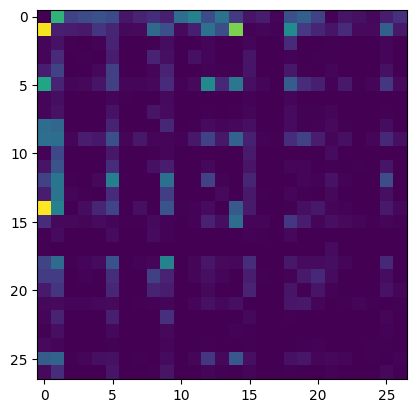

In [15]:
plt.imshow(N)

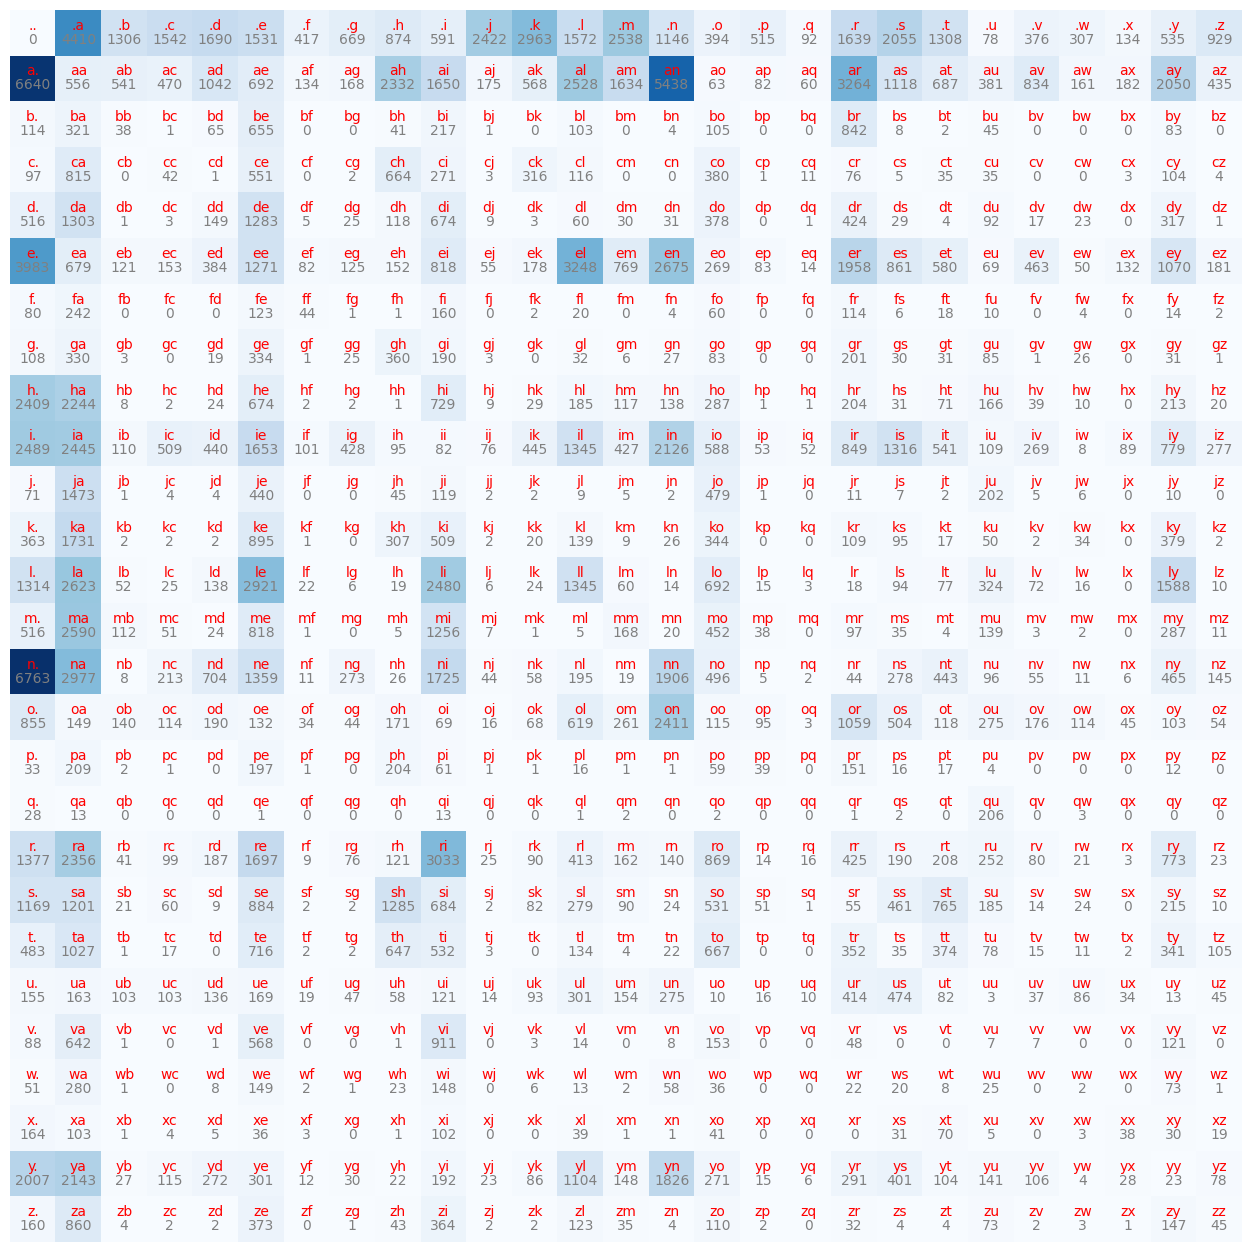

In [16]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='red')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

### Sample from the model

In [17]:
# turn the rows into probabilities, rather than counts, so we can sample from the row.
p = N[0].float()
p = p/p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [18]:
ix = torch.multinomial(p, num_samples=1, replacement=True).item()
itos[ix]

'v'

In [19]:
for _ in range(10):
    ix = 0
    out = []
    while True:
        p = N[ix].float()
        p = p/p.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True).item()
        if ix == 0:
            break
        out.append(itos[ix])

    print("".join(out))

aen
gahasistalymonchullemi
th
ossevuranesaega
t
wa
jaseyaiustah
ad
shietyl
narlusiroxovalee


In [20]:
# tensor.sum() dim reminder

a = torch.tensor([[1,2,3],[4,5,6]])
print(a)
print(a.shape)

tensor([[1, 2, 3],
        [4, 5, 6]])
torch.Size([2, 3])


In [21]:
print(a.sum())
dim_0 = a.sum(0, keepdim=True)
print(dim_0)
print(dim_0.shape)
dim_1 = a.sum(1, keepdim=True)
print(dim_1)
print(dim_1.shape)

tensor(21)
tensor([[5, 7, 9]])
torch.Size([1, 3])
tensor([[ 6],
        [15]])
torch.Size([2, 1])


In [22]:
# normalize

P = N.float()
P = P/P.sum(dim=1, keepdim=True)

In [23]:
for _ in range(10):
    ix = 0
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True).item()
        if ix == 0:
            break
        out.append(itos[ix])

    print("".join(out))

si
kligeriyra
dendean
llynabra
jus
ari
tra
fe
celon
pauapasamustisen


### Visualize probabilities

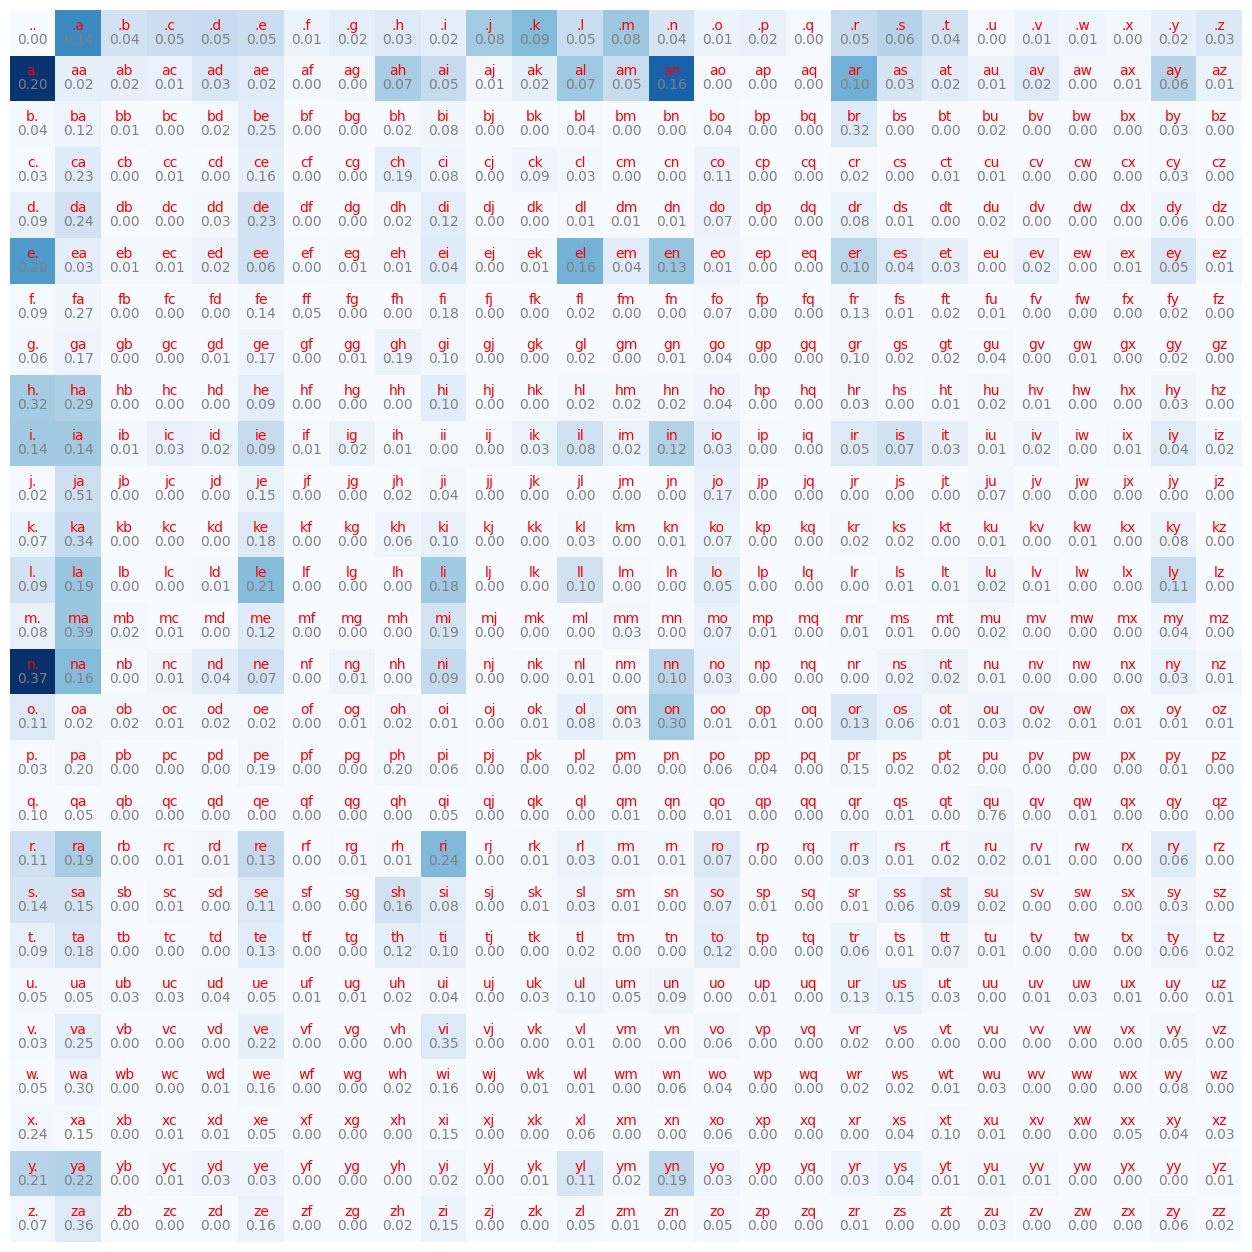

In [24]:
# view the 'weights' of this birgram model

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='red')
        plt.text(j, i, f"{P[i, j].item():.2f}", ha="center", va="top", color='gray')
plt.axis('off');

### Evaluate the quality of the model

In [25]:
# negative log likelihood

for w in words[:2]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = prob.log()
        print(f'{ch1}{ch2}, {prob:.4f}, {logprob:.4f}')

.e, 0.0478, -3.0408
em, 0.0377, -3.2793
mm, 0.0253, -3.6772
ma, 0.3899, -0.9418
a., 0.1960, -1.6299
.o, 0.0123, -4.3982
ol, 0.0780, -2.5508
li, 0.1777, -1.7278
iv, 0.0152, -4.1867
vi, 0.3541, -1.0383
ia, 0.1381, -1.9796
a., 0.1960, -1.6299


In [26]:
# negative log likelihood

log_likelihood = 0.0
n = 0

for w in words[:2]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = prob.log()
        print(f'{ch1}{ch2}, {prob:.4f}, {logprob:.4f}')
        log_likelihood+=logprob
        n+=1

print(f'\nlog likelihood: {log_likelihood:}')
print(f'negative log likelihood: {-log_likelihood}')
print(f'negative log likelihood(avg): {-log_likelihood/n}')

.e, 0.0478, -3.0408
em, 0.0377, -3.2793
mm, 0.0253, -3.6772
ma, 0.3899, -0.9418
a., 0.1960, -1.6299
.o, 0.0123, -4.3982
ol, 0.0780, -2.5508
li, 0.1777, -1.7278
iv, 0.0152, -4.1867
vi, 0.3541, -1.0383
ia, 0.1381, -1.9796
a., 0.1960, -1.6299

log likelihood: -30.080148696899414
negative log likelihood: 30.080148696899414
negative log likelihood(avg): 2.506679058074951


In [27]:
# negative log likelihood (average)

# with neural networks we want to train the model parameters
# to maximize the likelihood of the data

log_likelihood = 0.0
n = 0

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = prob.log()
        log_likelihood+=logprob
        n+=1

print(f'\nlog likelihood: {log_likelihood:}')
print(f'negative log likelihood: {-log_likelihood}')
print(f'negative log likelihood(avg): {-log_likelihood/n}')


log likelihood: -559891.75
negative log likelihood: 559891.75
negative log likelihood(avg): 2.454094171524048


## Part 2: neural network

### Training data

In [36]:
# create the training set of bigrams (x,y)

xs = []
ys = []

for w in words[:1]:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)


xs = torch.tensor(xs)
ys = torch.tensor(ys)



In [37]:
print(xs)
print(ys)

tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


### Training loop

In [42]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()


In [40]:
print(xenc)


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])


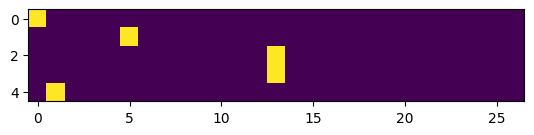

In [41]:
plt.imshow(xenc)

In [53]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float()

W = torch.randn(27,27, requires_grad=True)

logits = xenc @ W
counts = logits.exp()
probs = counts/counts.sum(dim=1, keepdim=True)
log_probs = probs.log()
loss = -log_probs[torch.arange(5), ys].mean()
loss

tensor(4.1910, grad_fn=<NegBackward0>)

In [80]:
xs = []
ys = []

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)


xs = torch.tensor(xs)
ys = torch.tensor(ys)

n = len(xs)
print(f"Number of bigrams: {n}")



Number of bigrams: 228146


In [81]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float()

W = torch.randn(27,27, requires_grad=True)



In [82]:
for i in range(100):

    # forward pass
    logits = xenc @ W
    counts = logits.exp()
    probs = counts/counts.sum(dim=1, keepdim=True)
    log_probs = probs.log()
    loss = -log_probs[torch.arange(n), ys].mean()
    print(f"loss:{loss}")

    # backward pass
    W.grad=None
    loss.backward()

    # step
    W.data += -20 * W.grad

loss:3.7728211879730225
loss:3.6077253818511963
loss:3.4777932167053223
loss:3.3702876567840576
loss:3.2790181636810303
loss:3.200598955154419
loss:3.13287353515625
loss:3.074256420135498
loss:3.023461103439331
loss:2.979356050491333
loss:2.9409050941467285
loss:2.9071857929229736
loss:2.8774235248565674
loss:2.850998878479004
loss:2.827425479888916
loss:2.8063113689422607
loss:2.7873334884643555
loss:2.77021861076355
loss:2.7547285556793213
loss:2.7406578063964844
loss:2.727828025817871
loss:2.7160863876342773
loss:2.7053017616271973
loss:2.6953611373901367
loss:2.686169147491455
loss:2.6776435375213623
loss:2.6697137355804443
loss:2.6623177528381348
loss:2.6554031372070312
loss:2.648923873901367
loss:2.642838954925537
loss:2.6371121406555176
loss:2.631713390350342
loss:2.6266140937805176
loss:2.6217896938323975
loss:2.617218255996704
loss:2.6128809452056885
loss:2.6087582111358643
loss:2.6048359870910645
loss:2.6010992527008057
loss:2.5975351333618164
loss:2.5941317081451416
loss:2.5

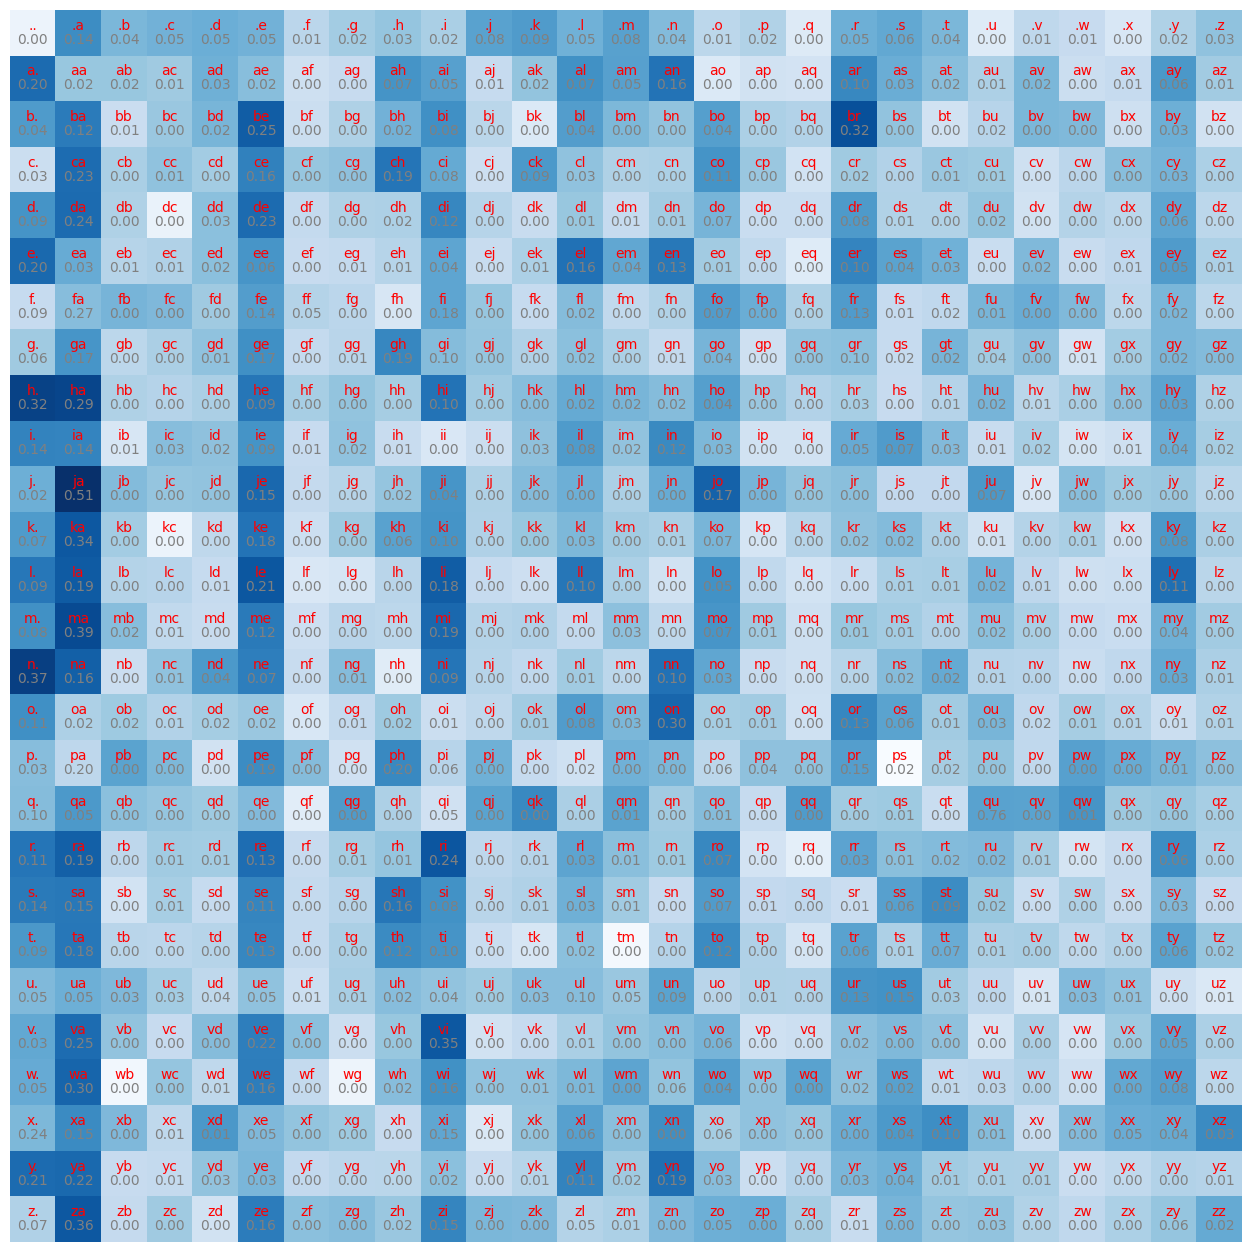

In [85]:
# view the 'weights' of this neural network

W.requires_grad=False
plt.figure(figsize=(16,16))
plt.imshow(W, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='red')
        plt.text(j, i, f"{P[i, j].item():.2f}", ha="center", va="top", color='gray')
plt.axis('off');

### Sample from the model

In [196]:
for i in range(5):

  out = []
  ix = 0
  while True:

    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------

    ix = torch.multinomial(p, num_samples=1, replacement=True).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

dmah.
colomakyaocjqde.
a.
h.
alosepzeqdangxdese.


# Notes

## Lessons from Makemore

### Train a language model using two different approaches and get the same result.
- First way: Language modeling using bigram counts (circa 1980's).
- Second way: Language modeling using neural network (single layer followed by softmax) with gradient based optimization

### Negative log likelihood
- Great exploration of negative log likelihood
- Evaluate the quality of a model (using negative log likelihood)
- Using negative log likelihood as a guide to optimizing a neural network

### Other topics
- Sampling from the model (using torch.multinomial)
- Training loop (fundamentally not much different from transformer)

### Pre-requisites:
 - Micrograd. (Then you will really appreciate Pytorch).

## When was Language modeling using bigram counts state of the art?

Language modeling using bigram counts was state of the art around the 1980s and early 1990s. During this period, statistical language models were a major focus of research in natural language processing (NLP). Here's a brief background on the development and significance of bigram models:

### Background

#### Pre-1980s: Early Language Models
- **1950s-1970s**: Early computational linguistics focused on rule-based approaches, such as context-free grammars, to model language. However, these approaches struggled with the variability and complexity of natural languages.

#### The Rise of Statistical Models
- **1980s**: The shift towards statistical models began, leveraging probabilistic methods to model language. The idea was to use the statistical properties of language derived from large text corpora to predict and generate text.

#### Bigram Models
- **Bigram Models**: A bigram model is a type of n-gram model where \( n = 2 \). It predicts the probability of a word based on the previous word:
  \[
  P(w_i | w_{i-1}) = \frac{\text{Count}(w_{i-1}, w_i)}{\text{Count}(w_{i-1})}
  \]
  where \( \text{Count}(w_{i-1}, w_i) \) is the frequency of the word pair (bigram) in the training corpus, and \( \text{Count}(w_{i-1}) \) is the frequency of the preceding word.

#### Key Developments
- **Jelinek-Mercer Smoothing (1980s)**: To address the issue of zero probabilities for unseen bigrams, techniques like Jelinek-Mercer smoothing were developed. These methods adjusted the probabilities to account for rare or unseen events.
- **Katz Backoff (1987)**: Ronald Katz introduced a backoff model, which would "back off" to lower-order n-grams (e.g., unigrams) when higher-order n-grams (e.g., bigrams) had zero counts.
- **Church and Gale (1990s)**: Kenneth Church and William Gale worked on improving statistical language models, including bigram models, to better handle large-scale text data.

#### Limitations of Bigram Models
- **Contextual Limitations**: Bigram models only consider the immediate previous word, making them insufficient for capturing long-range dependencies in language.
- **Sparse Data Problem**: Despite smoothing techniques, bigram models often struggled with data sparsity, especially in smaller corpora.

#### Transition to More Complex Models
- **Trigram Models**: To address the limitations of bigrams, trigram models (where \( n = 3 \)) and higher-order n-gram models were developed, providing better context by considering longer sequences of words.
- **Neural Language Models (2000s)**: By the late 1990s and early 2000s, researchers began exploring neural network-based language models. These models could capture more complex patterns and dependencies in language, leading to significant improvements in performance.
- **Recurrent Neural Networks (RNNs)**: RNNs, particularly LSTM (Long Short-Term Memory) networks, became popular for language modeling due to their ability to maintain context over longer sequences.

### Conclusion
While bigram models were state of the art in the 1980s and early 1990s, they were eventually surpassed by more advanced n-gram models and neural network-based approaches. The evolution from bigram models to modern neural language models highlights the rapid advancements in the field of NLP and the ongoing quest to better understand and model natural language.

## Github raw files

### GitHub serves files through different URLs.

1. **HTML Document Download (First Line)**
   ```sh
   !wget https://github.com/karpathy/makemore/blob/master/names.txt
   ```
   When you use the above URL, you are accessing the GitHub web interface for the file. This URL points to an HTML page that displays the file `names.txt` within the GitHub repository. Therefore, using `wget` on this URL results in downloading the HTML content of the web page rather than the raw text file.

2. **Text File Download (Second Line)**
   ```sh
   !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
   ```
   This URL points directly to the raw content of the `names.txt` file. The `raw.githubusercontent.com` domain serves the actual file content directly, without any HTML wrapping. Therefore, when you use `wget` on this URL, you get the text file as expected.

### Explanation

- **GitHub Web Interface (`https://github.com/...`)**
  - Accessing files through this URL serves the file as part of a GitHub HTML page. The HTML page includes the GitHub interface, navigation, and other elements.

- **Raw File Content (`https://raw.githubusercontent.com/...`)**
  - Accessing files through this URL serves the file's raw content directly. This is specifically designed for fetching files in their plain text format.

### Summary

When downloading files from GitHub, always use the `https://raw.githubusercontent.com/...` URL pattern to obtain the raw content of the file. The `https://github.com/...` URL pattern is for viewing the file in a web browser with the GitHub interface.

This distinction is crucial for automation scripts or any application where you need to programmatically access the content of files hosted on GitHub.

## How to delete a file in a Colab notebook

```python
import os

# Path to the file
file_path = 'names.txt'

# Check if the file exists
if os.path.exists(file_path):
    # Delete the file
    os.remove(file_path)
    print(f"{file_path} has been deleted.")
else:
    print(f"{file_path} does not exist.")
```